# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [13]:
# Imports 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import zipfile
import os
from urllib.request import urlretrieve
import cv2

%matplotlib inline

## Step 0: Dataset Download
Download link: https://d17h27t6h515a5.cloudfront.net/topher/2016/October/5811165e_traffic-signs-data.zip/traffic-signs-data.zip.zip

Rename train.p and test.p to train.pickle and test.pickle, respectively

In [2]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    print('Downloading ' + file + '...')
    if not os.path.isfile(file):
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File already in the filesystem!')

download('https://d17h27t6h515a5.cloudfront.net/topher/2016/October/5811165e_traffic-signs-data.zip/traffic-signs-data.zip.zip', 'traffic-signs-data.zip.zip')


File already in the filesystem!


In [4]:
train_filename = 'train.pickle'
test_filename = 'test.pickle'

if not os.path.isfile(train_filename) or not os.path.isfile(test_filename):
    # Unzip
    print('Unzipping file...')
    with zipfile.ZipFile("traffic-signs-data.zip.zip","r") as zip_ref:
        zip_ref.extractall()

    # Rename    
    print('Renaming pickle files...')
    os.rename('train.p', 'train.pickle')
    os.rename('test.p', 'test.pickle')
    print('Done')
else:
    print('Pickle files already in the filesystem!')


Pickle files already in the filesystem!


---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [6]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.pickle'
testing_file = 'test.pickle'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
### To start off let's do a basic data summary.
# TODO: number of training examples
n_train = len(y_train)

# TODO: number of testing examples
n_test = len(y_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:3]

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

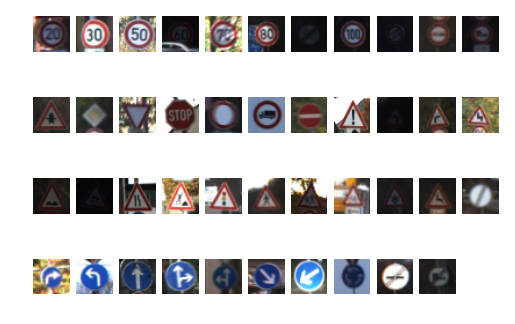

In [9]:
# Plot one example of the 43 different classes
_, idx = np.unique(y_test, return_index=True)
X_test_unique = X_test[idx, :, :, :]
for i in range(0, len(idx)):
    plt.subplot(4, 11, i+1)
    plt.imshow(X_test_unique[i, :, :, :]);
    plt.axis('off')

In [10]:
# Print the labels
with open('signnames.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        print(', '.join(row))

ClassId, SignName
0, Speed limit (20km/h)
1, Speed limit (30km/h)
2, Speed limit (50km/h)
3, Speed limit (60km/h)
4, Speed limit (70km/h)
5, Speed limit (80km/h)
6, End of speed limit (80km/h)
7, Speed limit (100km/h)
8, Speed limit (120km/h)
9, No passing
10, No passing for vechiles over 3.5 metric tons
11, Right-of-way at the next intersection
12, Priority road
13, Yield
14, Stop
15, No vechiles
16, Vechiles over 3.5 metric tons prohibited
17, No entry
18, General caution
19, Dangerous curve to the left
20, Dangerous curve to the right
21, Double curve
22, Bumpy road
23, Slippery road
24, Road narrows on the right
25, Road work
26, Traffic signals
27, Pedestrians
28, Children crossing
29, Bicycles crossing
30, Beware of ice/snow
31, Wild animals crossing
32, End of all speed and passing limits
33, Turn right ahead
34, Turn left ahead
35, Ahead only
36, Go straight or right
37, Go straight or left
38, Keep right
39, Keep left
40, Roundabout mandatory
41, End of no passing
42, End of n

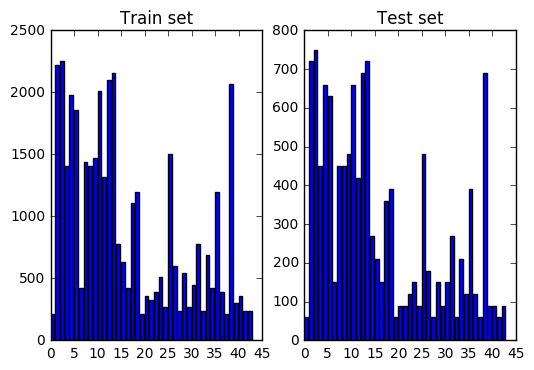

In [11]:
# Display the number of examples for each class, for training and test set
labels = np.array(range(0, n_classes))
train_n_examples = np.zeros(n_classes, dtype=np.int32)
test_n_examples = np.zeros(n_classes, dtype=np.int32)
for i in labels:
    # Get indices in Y that correspond to 'i', for train and test sets
    train_n_examples[i] = sum(y_train == i)
    test_n_examples[i] = sum(y_test == i)

# Plot in a bar diagram
plt.subplot(1,2,1)
plt.bar(labels, train_n_examples);
plt.title('Train set');
plt.subplot(1,2,2)
plt.bar(labels, test_n_examples);    
plt.title('Test set');

We can observe that the training data is **not equally distributed** among the different classes. This indicates that the algorithm will be more fine-tuned for those classes for which there are more examples. If we want to improve the network's ability to generalize, we should have roughly the same number of examples for each class. This could be accomplished by generating synthetic data.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [24]:
### RGB to grayscale conversion. According to the paper, it gives better results
def rgb_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Normalization: zero mean and unit variance
def normalization(x):
    a = 0.1
    b = 0.9
    x_min = 0
    x_max = 255
    
    return a + (x - x_min) * (b - a) / (x_max - x_min)

def preprocess_set(dataset):
    # Declare output array
    dataset_preprocessed = np.zeros(dataset.shape[0:3])
    print(dataset_preprocessed.shape)
    # Convert from RGB to grayscale
    for i in range(0, dataset.shape[0]):
        dataset_preprocessed[i, :, :] = rgb_to_grayscale(dataset[i, :, :, :])
    
    # Perform normalization
    dataset_preprocessed = normalization(dataset_preprocessed)
    
    return dataset_preprocessed  



In [25]:
print('Preprocessing train and test datasets...')
X_train_preprocessed = preprocess_set(X_train)
X_test_preprocessed = preprocess_set(X_test)
print('Done')

Preprocessing train and test datasets...
(39209, 32, 32)
(12630, 32, 32)
Done


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

The following techniques have been used to preprocess the data:

-**RGB to grayscale conversion**. According to the paper, this results in a slightly better performance. In addition, this will make our network easier to train, since the input is a 32x32 image instead of 32x32x3

-**Normalization**. The goal is to make the inputs have approximately zero mean and unit variance.

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [26]:
### Additional data generation

In [ ]:
### Dataset splitting
X_train_final = ...
X_validation_final = ...
X_test_final = ...

y_train_final = ...
y_validation_final = ...
y_test_final = ...

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

---
## 2.1. Network architecture

In [27]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [29]:
### Helper functions
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape))    
    
def create_biases(shape):    
    return tf.Variable(tf.zeros(shape))
    
def create_conv_layer(input_layer,          # 4D tensor
                      filter_size,          # scalar
                      n_filters,            # scalar
                      use_pooling=True):    # boolean
    # Review https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#conv2d
    # for conventions about input shapes
    
    # Create weights (4D tensor) and biases (1D vector)
    input_depth = input_layer.shape[3]
    weight_shape = [filter_size, filter_size, input_depth, n_filters]
    bias_shape = [n_filters]
    
    weights = create_weights(weight_shape)
    biases = create_biases(bias_shape)
    
    # Convolution
    layer = layertf.nn.conv2d(input=input_layer, 
                              filter=weights,
                              strides=[1,1,1,1], 
                              padding='SAME')
    # Add bias
    layer += biases
    
    # Max pooling
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1,2,2,1],
                               strides=[1,2,2,1],
                               padding='SAME')
    
    # ReLU. Should be applied before pooling. However the result is the same and in this
    # case we perform fewer computations, since there are fewer pixels
    layer = tf.nn.relu(layer)
    
    return layer

def create_fc_layer(input_layer,       # 2D matrix [?, n_inputs]
                    n_outputs):        # scalar

    n_inputs = input_layer.shape[1]
    weights = create_weights([n_inputs, n_outputs])
    biases = create_biases([n_outputs])
    
    # XW + b
    layer = tf.matmul(input_layer, weights) + biases
    
    # ReLU
    layer = tf.nn.relu(layer)
    
    return layer   
    
                   
def flatten_layer(layer):
    # Shape is [batch_size, img_w, img_h, img_depth]    
    layer_shape = layer.get_shape()
    
    # Number of features per image
    num_images = layer_shape[0]
    num_features = np.array(layer_shape[1:4], dtype=int).prod()
    
    # Must reshape into [batch_size, n_features]
    return tf.reshape(layer, [num_images, num_features])

In [28]:
### Network parameters
# Input
img_size_w = X_train.shape[1]
img_size_h = X_train.shape[2]
img_size_d = 1  # Using grayscale
img_size_total = img_size_w * img_size_h * img_size_d

# Conv layer 1
layer1_filter_size = 5
layer1_n_filters = 16

# Conv layer 2
layer2_filter_size = 5
layer2_n_filters = 32

# Fully Connected 1
fc1_n_neurons = 128

# Fully Connected 2
fc2_n_neurons = n_classes

In [ ]:
### Placeholder variables
n_channels = 1

nn_input = tf.placeholder(tf.float32, shape=[None, img_size_w, img_size_h, n_channels], name='x')
nn_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y')

nn_true_class = tf.argmax(nn_true, dimension=1)

In [ ]:
### Network architecture

# First Layer: Conv + ReLU + Max pool
layer1 = create_conv_layer(input_layer=nn_true,
                           filter_size=layer1_filter_size,
                           n_filters=layer1_n_filters,
                           use_pooling=True)

# Second Layer: Conv + ReLU + Max pool
layer2 = create_conv_layer(input_layer=layer1,
                           filter_size=layer2_filter_size,
                           n_filters=layer2_n_filters,
                           use_pooling=True)

# Third Layer: Fully Connected + ReLU
flattened_layer2 = flatten_layer(layer2)
layer3 = create_fc_layer(input_layer=flattened_layer2,
                         n_outputs=fc1_n_neurons)

# Fourth Layer: Fully Connected + ReLU
layer4 = create_fc_layer(input_layer=layer3,
                         n_outputs=fc2_n_neurons)
# Softmax
y_predicted = tf.nn.softmax(layer4)
y_predicted_class = tf.argmax(y_predicted, dimension=1)

In [ ]:
### Optimization
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer4,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

learning_rate_ = 0.1
optimizer = tf.train.AdapOptimizer(learning_rate_).minimize(cost)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

---
## 2.2 Network training

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [ ]:
# Training paramters
train_batch_size = 128
learning_rate = 0.1
epochs = 5

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.